Profile Columns ['CMANAME', 'CMAUID', 'CSDNAME', 'CSDUID', 'public_caf', 'public_ef', 'public_emp', 'public_gs', 'public_hf', 'public_psef', 'public_srf', 'walk_caf', 'walk_ef', 'walk_emp', 'walk_gs', 'walk_hf', 'walk_psef', 'walk_srf', 'ada_code_n', 'ADA_code']
ACS Columns ['CMANAME', 'CMAUID', 'CSDNAME', 'CSDUID', 'PRNAME', 'ada_code_n', 'ADA_code', 'T1527', 'T1528', 'T1529', 'T1530', 'T1531', 'T1532', 'T1533', 'T1534', 'T1535', 'T1536', 'T1537', 'T1538', 'T1539', 'T1540', 'T1541', 'T1542', 'T1543', 'T1544', 'T1545', 'T1546', 'T1547', 'T1548', 'T1549', 'T1550', 'T1551', 'T1552', 'T1553', 'T1554', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1575', 'T1576', 'T1577', 'T1578', 'T1579', 'T1580', 'T1581', 'T1582', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'

ImportError: The 'mapclassify' package (>= 2.4.0) is required to use the 'scheme' keyword.

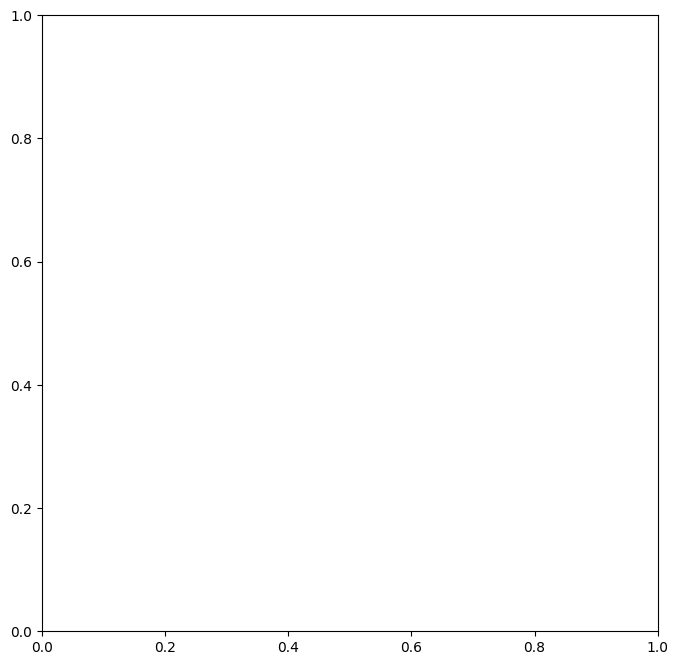

In [2]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt

# 1) Load the ADA shapefile
ada_geo = gpd.read_file("/Users/preciousajilore/Documents/GitHub/Misc/BDG/lada000b21a_e.shp")

# 2) Keep only Alberta (PRUID == "48") and project to Web-Mercator
ada_ab = ada_geo[ada_geo["PRUID"] == "48"].to_crs(epsg=3857)

# 3) Build the 8-digit ADA_code key on the geometry side
ada_ab["ADA_code"] = ada_ab["ADAUID"].astype(str).str.zfill(8)

#Load dataset
#Load the data and merge the datasets
#Load the Datasets
profile_df = pd.read_csv("/Users/preciousajilore/Documents/GitHub/Misc/BDG/ADA_acs_file.csv", skiprows= 1)
acs_df = pd.read_csv("/Users/preciousajilore/Documents/GitHub/Misc/BDG/ADA_profile_simplified.csv")

print("Profile Columns", profile_df.columns.to_list())
print("ACS Columns", acs_df.columns.to_list())

# 2) Merge on ADA_code
#Merge Datasets on ADA_code
df = pd.merge(profile_df, acs_df, on='ADA_code', how='inner')

#Please work lol
df.head()

# 6) Rename the public-transit indices for clarity
df = df.rename(columns={
    "public_hf":   "access_hf",    # health facilities
    "public_srf":  "access_srf",   # sports & rec centres
    "public_psef": "access_psef"   # post-secondary institutions
})

# 7) Make sure ADA_code is zero-padded string on the attribute side too
df["ADA_code"] = df["ADA_code"].astype(str).str.zfill(8)

# 8) Merge attributes into the geometries
gdf_ab = ada_ab.merge(
    df[["ADA_code","access_hf","access_srf","access_psef","CMANAME_x"]],
    on="ADA_code",
    how="left"
)

# 9) Filter to just Edmonton CMAs
gdf_ed = gdf_ab[
    gdf_ab["CMANAME_x"].str.contains("Edmonton", case=False, na=False)
].copy()

# 10) Plot a choropleth of the health-access index
fig, ax = plt.subplots(figsize=(8,8))
gdf_ed.plot(
    column="access_hf",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    legend=True,
    edgecolor="white",
    linewidth=0.2,
    ax=ax
)

# 11) (Optional) Add a neutral basemap underneath
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    crs=gdf_ed.crs,
    reset_extent=False
)

# 12) Final styling
ax.set_title("Edmonton ADAs — Health Accessibility Index\n(0 = worst access, 1 = best)")
ax.axis("off")
plt.tight_layout()
plt.show()
